# 2022-10-12 Krylov and preconditioning

## Last time

* Classical iterative methods
* Concept of preconditioning

## Today
* Krylov methods (focus on GMRES)
* PETSc experiments
* Simple preconditioners

In [3]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function advdiff_matrix(n; kappa=1, wind=[0, 0])
    h = 2 / (n + 1)
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    idx((i, j),) = (i-1)*n + j
    in_domain((i, j),) = 1 <= i <= n && 1 <= j <= n
    stencil_advect = [-wind[1], -wind[2], 0, wind[1], wind[2]] / h
    stencil_diffuse = [-1, -1, 4, -1, -1] * kappa / h^2
    stencil = stencil_advect + stencil_diffuse
    for i in 1:n
        for j in 1:n
            neighbors = [(i-1, j), (i, j-1), (i, j), (i+1, j), (i, j+1)]
            mask = in_domain.(neighbors)
            append!(rows, idx.(repeat([(i,j)], 5))[mask])
            append!(cols, idx.(neighbors)[mask])
            append!(vals, stencil[mask])
        end
    end
    sparse(rows, cols, vals)
end

advdiff_matrix (generic function with 1 method)

# Krylov subspaces

All matrix iterations work with approximations in a *Krylov subspace*, which has the form

$$ K_n = \big[ b \big| Ab \big| A^2 b \big| \dotsm \big| A^{n-1} b \big] . $$

This matrix is horribly ill-conditioned and cannot stably be computed as written.  Instead, we seek an orthogonal basis $Q_n$ that spans the same space as $K_n$.  We could write this as a factorization

$$ K_n = Q_n R_n $$

where the first column $q_0 = b / \lVert b \rVert$.  The $R_n$ is unnecessary and hopelessly ill-conditioned, so a slightly different procedure is used.

# Arnoldi iteration

The Arnoldi iteration applies orthogonal similarity transformations to reduce $A$ to [Hessenberg form](https://en.wikipedia.org/wiki/Hessenberg_matrix), starting from a vector $q_0 = b$,

$$ A = Q H Q^* . $$

Let's multiply on the right by $Q$ and examine the first $n$ columns,

$$ A Q_n = Q_{n+1} H_n $$
where $H_n$ is an $(n+1) \times n$ Hessenberg matrix.

# Aside: Conditioning of Arnoldi process
The Arnoldi process is well-conditioned because $Q$ is orthogonal and

$$ \lVert H_n \rVert \le \lVert Q_{n+1}^* \rVert \lVert A \rVert \lVert Q_n \rVert \le \lVert A \rVert $$.

For a lower bound, we have

$$ \sigma_{\min}(A)^2 \le x^* A^* A x $$

for all $x$ of norm 1.  It must also be true for any $x = Q_n y$ where $\lVert y\rVert = 1$, thus

$$ \sigma_{\min}(A)^2 \le y^* Q_n^* A^* A Q_n y = y^* H_n^* Q_{n+1}^* Q_{n+1} H_n y = y^* H_n^* H_n y . $$

# GMRES
$$ A Q_n = Q_{n+1} H_n $$

GMRES (Generalized Minimum Residual) minimizes
$$ \lVert A x - b \rVert $$
over the subspace $Q_n$.  I.e., $x = Q_n y$ for some $y$.  By the Arnoldi recurrence, this is equivalent to
$$ \lVert Q_{n+1} H_n y - b \lVert $$
which can be solved by minimizing
$$ \lVert H_n y - Q_{n+1}^* b \rVert . $$
Since $q_0 = b/\lVert b \lVert$, the least squares problem is to minimize
$$ \Big\lVert H_n y - \lVert b \rVert e_0 \Big\rVert . $$
The solution of this least squares problem is achieved by incrementally updating a $QR$ factorization of $H_n$.

## Notes
* The solution $x_n$ constructed by GMRES at iteration $n$ is not explicitly available.  If a solution is needed, it must be constructed by solving the $(n+1)\times n$ least squares problem and forming the solution as a linear combination of the $n$ vectors $Q_n$.  The leading cost is $2mn$ where $m \gg n$.
* The residual vector $r_n = A x_n - b$ is not explicitly available in GMRES.  To compute it, first build the solution $x_n$ as above.
* GMRES minimizes the 2-norm of the residual $\lVert r_n \rVert$ which is equivalent to the $A^* A$ norm of the error $\lVert x_n - x_* \rVert_{A^* A}$.

# More notes on GMRES

* GMRES needs to store the full $Q_n$, which is unaffordable for large $n$ (many iterations).  The standard solution is to choose a "restart" $k$ and to discard $Q_n$ and start over with an initial guess $x_k$ after each $k$ iterations.  This algorithm is called GMRES(k).  PETSc's default solver is GMRES(30) and the restart can be controlled using the run-time option `-ksp_gmres_restart`.
* Most implementations of GMRES use classical Gram-Schmidt because it is much faster in parallel (one reduction per iteration instead of $n$ reductions per iteration).  The PETSc option `-ksp_gmres_modifiedgramschmidt` can be used when you suspect that classical Gram-Schmidt may be causing instability.
* There is a very similar (and older) algorithm called GCR that maintains $x_n$ and $r_n$.  This is useful, for example, if a convergence tolerance needs to inspect individual entries.  GCR requires $2n$ vectors instead of $n$ vectors, and can tolerate a nonlinear preconditioner.  FGMRES is a newer algorithm with similar properties to GCR.

# Experiments in [PETSc](https://petsc.org)

* PETSc = Portable Extensible Toolkit for Scientific computing
* `./configure`, `make`
  * Depends on BLAS and LAPACK (default system or package manager)
    * or `./configure --download-f2cblaslapack --download-blis`
  * Depends on MPI for parallelism (package manager)
    * or `./configure --download-mpich` (or `--download-openmpi`)
* `docker run -it --rm jedbrown/petsc`
* Lots of examples (mostly C and Fortran, some Python)
* Experimental bindings in Rust, Julia
* We'll use `src/snes/tutorials/ex15.c`
  * "p-Bratu": combines p-Laplacian with Bratu nonlinearity
  $$ -\nabla\cdot\big(\kappa(\nabla u) \nabla u\big) - \lambda e^u = f $$
  * Newton solver with Krylov on each iteration

# Simple preconditioners

## Jacobi `-pc_type jacobi`

$$ P_{\text{Jacobi}}^{-1} = D^{-1} $$
where $D$ is the diagonal of $A$.

## Gauss-Seidel `-pc_type sor`

$$ P_{GS}^{-1} = (L+D)^{-1} $$
where $L$ is the (strictly) lower triangular part of $A$.  The upper triangular part may be used instead, or a symmetric form
$$ P_{SGS}^{-1} = (L+U)^{-1} A \Big( I - (L+D)^{-1} \Big) . $$

### Over-relaxation

`-pc_sor_omega 1.` is default (Gauss-Seidel)

## Run p-Laplacian example
```console
$ cd src/snes/tutorials
$ make ex15
$ ./ex15 -da_refine 2 -dm_view
$ ./ex15 -ksp_monitor -pc_type jacobi
$ ./ex15 -snes_view
```

## Experiments

* How does iteration count vary under grid refinement?
* How sensitive is it to parameters
  * p-Laplacian `-p` $> 1$ and `-epsilon` $> 0$
  * Bratu `-lambda` $< 6.8$
* How sensitive to `-ksp_gmres_restart`?
* `-ksp_monitor_true_residual`
* `-ksp_view_eigenvalues`

# Symmetric problems

## Lanczos iteration: like GMRES for symmetric problems

If $A$ is symmetric, then $H = Q^T A Q$ is also symmetric.  Since $H$ is Hessenberg, this means $H$ is tridiagonal.  Instead of storing $Q_n$, it is sufficient to store only the last two columns since the iteration satisfies a 3-term recurrence.  The analog of GMRES for the symmetric case is called MINRES and is also useful for solving symmetric indefinite problems.

## Conjugate Gradients: changing the norm

Instead of minimizing the $A^T A$ norm of the error, the Conjugate Gradient method minimizes the $A$ norm of the error.  For $A$ to induce a norm, it must be symmetric positive definite.  [Jeremy Shewchuck's guide to CG](http://www.cs.cmu.edu/%7Equake-papers/painless-conjugate-gradient.pdf) is an excellent resource.

# Incomplete factorization

* Start factoring like in a sparse direct solver
  * **ILU(0)** Discard fill outside the sparsity pattern of $A$
  * **ILU($k$)**: only allow $k$ levels of fill
  * **ILUT($\epsilon$)**: only keep fill values larger than $\epsilon$

## Experiments
* Try `-pc_factor_levels 2`
* Impact on cost (check `-log_view`)
* Impact on scalability (`-da_refine 6`)

## Kershaw (1978) matrix

Incomplete Cholesky can break down for SPD matrices.

```console
$ make $PETSC_ARCH/tests/ksp/pc/tutorials/ex1
```
and try running.

In [16]:
K = [3 -2 0 2; -2 3 -2 0; 0 -2 3 -2; 2 0 -2 3]
eigvals(K)

4-element Vector{Float64}:
 0.17157287525380904
 0.17157287525381085
 5.828427124746186
 5.82842712474619

# Domain decomposition

![](https://upload.wikimedia.org/wikipedia/commons/a/a9/Ddm_original_logo.png)

## Alternating Schwarz method
```python
bc_circ = guess()
while not converged:
    u_circ = solve(A_circ, bc_circ)
    bc_rect = eval(u_circ, rect)
    u_rect = solve(A_rect, bc_rect)
    bc_circ = eval(u_rect, circ)
```

This method was proposed in 1870 by [Hermann Schwarz](https://en.wikipedia.org/wiki/Hermann_Schwarz) as a theoretical tool, and is now called a **multiplicative** Schwarz method because the solves depend on each other.  We can see it as a generalization of Gauss-Seidel in which we solve on subdomains instead of at individual grid points.  As with Gauss-Seidel, it is difficult to expose parallelism.

# Additive Schwarz

The additive Schwarz method is more comparable to Jacobi, with each domain solved in parallel.  Our fundamental operation will be an embedding of each subdomain $V_i$ into the global domain $V$, which we call the **prolongation**

$$ P_i : V_i \to V $$

The transpose of prolongation, $P_i^T$, will sometimes be called **restriction**.
Let's work an example.

In [25]:
n = 21
x = LinRange(-1, 1, n)
overlap = 0
domains = [(1, n÷3), (n÷3+1, 2*n÷3), (2*n÷3+1, n)]
Id = diagm(ones(n))
P = []
for (i, (left, right)) in enumerate(domains)
    push!(P, Id[:, left:right])
end

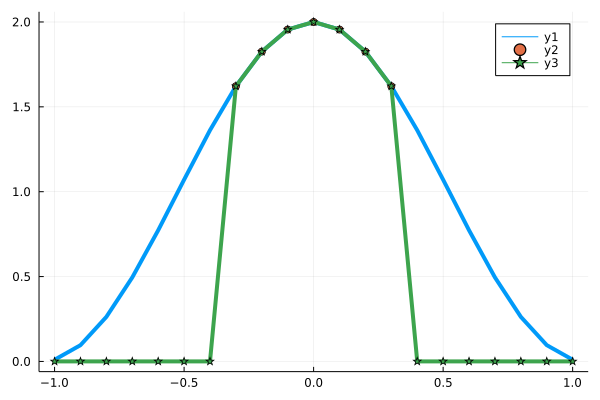

In [27]:
u = 1 .+ cos.(3*x)
plot(x, u)
u_2 = P[2]' * u
scatter!(P[2]' * x, u_2)
plot!(x, P[2] * u_2, marker=:auto)

# The algorithm

Define the subdomain operator $$A_i = P_i^T A P_i$$
The additive Schwarz preconditioner is
$$ M^{-1} = \sum_i P_i A_i^{-1} P_i^T $$
and it has error iteration matrix
$$ I - \sum_i  P_i A_i^{-1} P_i^T A $$

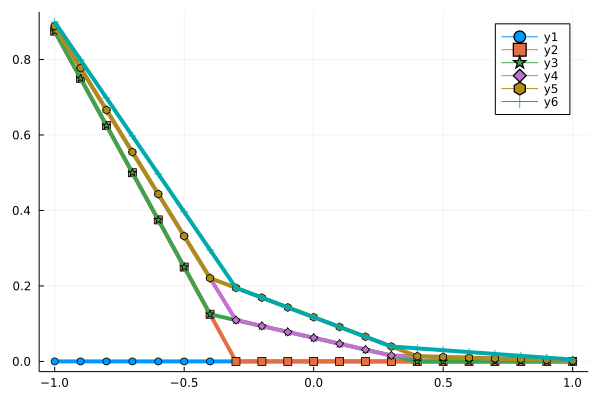

In [30]:
A = diagm(0 => 2*ones(n), -1 => -ones(n-1), 1 => -ones(n-1))
b = zeros(n); b[1] = 1
u = zero(b) # initial guess
us = [u]
for _ in 1:5
    r = b - A * u # residual
    u_next = copy(u);
    for Pi in P
        Ai = Pi' * A * Pi
        ui = Ai \ (Pi' * r)
        u_next += Pi * ui
    end
    u = u_next; push!(us, u)
end
plot(x, us, marker=:auto)

# Theory
Given a linear operator $A : V \to V$, suppose we have a collection of prolongation operators $P_i : V_i \to V$.  The columns of $P_i$ are "basis functions" for the subspace $V_i$.  The Galerkin operator $A_i = P_i^T A P_i$ is the action of the original operator $A$ in the subspace.

Define the subspace projection

$$ S_i = P_i A_i^{-1} P_i^T A . $$

* $S_i$ is a projector: $S_i^2 = S_i$
* If $A$ is SPD, $S_i$ is SPD with respect to the $A$ inner product $x^T A y$
* $I - S_i$ is $A$-orthogonal to the range of $P_i$

In [23]:
A2 = P[2]' * A * P[2]
S2 = P[2] * inv(A2) * P[2]' * A
norm(S2^2 - S2)

1.2036131040197588e-15

In [24]:
norm(P[2]' * A * (I - S2))

1.1831170202396054e-15

**Note:** The concept of $A$-orthogonality is meaningful only when $A$ is SPD.
Does the mathematical expression $ P_i^T A (I - S_i) = 0 $ hold even when $A$ is nonsymmetric?

# Convergence theory

The formal convergence is beyond the scope of this course, but the following estimates are useful.  We let $h$ be the element diameter, $H$ be the subdomain diameter, and $\delta$ be the overlap, each normalized such that the global domain diameter is 1.  We express the convergence in terms of the condition number $\kappa$ for the preconditioned operator.

* (Block) Jacobi: $\delta=0$, $\kappa \sim H^{-2} H/h = (Hh)^{-1}$
* Overlapping Schwarz: $\kappa \sim H^{-2} H/\delta = (H \delta)^{-1}$
* 2-level overlapping Schwarz: $\kappa \sim H/\delta$

* Additive $ I - \sum_{i=0}^n S_i, $

* Multiplicative $ \prod_{i=0}^n (I - S_i), $
* Hybrid $ (I - S_0) (I - \sum_{i=1}^n S_i) . $

In each case above, the action is expressed in terms of the error iteration operator.

# PETSc experiments

* Compare domain decomposition and multigrid preconditioning
 * `-pc_type asm` (Additive Schwarz)
  * `-pc_asm_type basic` (symmetric, versus `restrict`)
  * `-pc_asm_overlap 2` (increase overlap)
  * Effect of direct subdomain solver: `-sub_pc_type lu`

* Symmetric example: `src/snes/examples/tutorials/ex5.c`
* Nonsymmetric example: `src/snes/examples/tutorials/ex19.c`
* Compare preconditioned versus unpreconditioned norms.
* Compare BiCG versus GMRES
 * `-pc_type mg` (Geometric Multigrid)
* Use monitors:
 * `-ksp_monitor_true_residual`
 * `-ksp_monitor_singular_value`
 * `-ksp_converged_reason`
* Explain methods: `-snes_view`
* Performance info: `-log_view`